Below is a list of imports we will need to do to run the program

Install packages missing from Google Colab

In [ ]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 84 kB 2.6 MB/s 
     |████████████████████████████████| 588.3 MB 6.5 kB/s 
     |████████████████████████████████| 189 kB 65.5 MB/s 
     |████████████████████████████████| 16.2 MB 52.5 MB/s 
     |████████████████████████████████| 40 kB 6.5 MB/s 
     |████████████████████████████████| 154 kB 71.7 MB/s 
     |████████████████████████████████| 8.3 MB 58.0 MB/s 
     |████████████████████████████████| 237 kB 76.1 MB/s 
     |████████████████████████████████| 51 kB 8.0 MB/s 
     |████████████████████████████████| 439 kB 71.9 MB/s 
     |████████████████████████████████| 6.0 MB 64.8 MB/s 
     |████████████████████████████████| 1.7 MB 61.0 MB/s 
     |████████████████████████████████| 85 kB 5.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
   

In [ ]:
import numpy as np
import pandas as pd

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import os
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras import optimizers, losses
# For data preprocessing
from keras.preprocessing.image import ImageDataGenerator
import pickle

# For Graphing
import matplotlib.pyplot as plt

# For converting to TFJS
import tensorflowjs as tfjs

device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


Create a folder to hold the TF model files

In [ ]:
!mkdir OUTPUT_MODEL

Installs Kaggle Dataset into Google Colab (or python notebook)

In [ ]:
! pip install -q kaggle
! gdown --id 1MTD1C7Svz5RtEKv9cdnsRM6P6MySZwLN
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d gpiosenka/100-bird-species
! unzip 100-bird-species.zip

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1MTD1C7Svz5RtEKv9cdnsRM6P6MySZwLN
To: /content/kaggle.json
100% 65.0/65.0 [00:00<00:00, 98.3kB/s]
 61% 1.03G/1.69G [00:51<00:43, 16.4MB/s]

(OPTIONAL) Hyperparamterization function

In [ ]:
def trainer(hyp) :
  # create model object
  model = keras.Sequential([
  #adding first convolutional layer    
  keras.layers.Conv2D(
      #adding filter 
      filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
      # adding filter size or kernel size
      kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
      #activation function
      activation='relu',
      input_shape=(150, 150, 3)),
  # adding second convolutional layer 
  keras.layers.Conv2D(
      #adding filter 
      filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
      #adding filter size or kernel size
      kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
      #activation function
      activation='relu'
  ),
  # adding flatten layer    
  keras.layers.Flatten(),
  # adding dense layer    
  keras.layers.Dense(
      units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
      activation='relu'
  ),
  # output layer    
  keras.layers.Dense(450, activation='softmax')
  ])
  #compilation of model
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
  return model

Define # of Epochs

In [ ]:
epochs = 30

Found 70626 images belonging to 450 classes.
Found 2250 images belonging to 450 classes.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)     

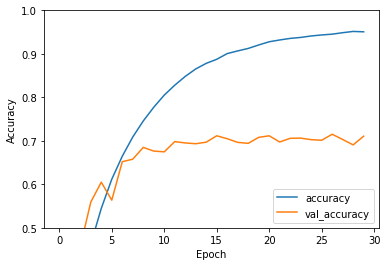

In [ ]:
 # Image data from the Kaggle dataset is of the size 224 X 224 X3
# Target image size is 150 X 150 X 3 normalized
datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory(
        'train',
        target_size=(150, 150),
        batch_size=256,
        class_mode='categorical')
validation_generator = datagen.flow_from_directory(
        'valid',
        target_size=(150, 150),
        batch_size=256,
        class_mode='categorical')

# (OPTIONAL) using hyperparameterization function
#tuner = RandomSearch(trainer,
                  #  objective='val_accuracy',
                 #   max_trials = 5)
# search best parameter
#tuner.search(train_df,train_labl,epochs=3,validation_data=(train_df,train_labl))

# Create model archeticture
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(150, 150,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

num_classes = 450;
input_shape = (150, 150, 3)
with tf.device(device_name):
  model = tf.keras.models.Sequential([
      #data_augmentation,
      # Note the input shape is the desired size of the image 150x150 with 3 bytes color
      # This is the first convolution
      tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=input_shape),
      tf.keras.layers.MaxPooling2D(2, 2),
      # The second convolution
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      # The third convolution
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      # The fourth convolution
      tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      # Flatten the results to feed into a DNN
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.2),
      # 512 neuron hidden layer
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(num_classes, activation='softmax')
  ])
  model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

#model = tf.keras.models.Sequential([
 #   tf.keras.layers.Conv2D(75, (3, 3), activation='relu', input_shape=input_shape),
  #  tf.keras.layers.MaxPooling2D(2,2),
   # tf.keras.layers.Flatten(),
    #tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Dense(num_classes, activation='softmax')
#])

# Other alternative activation functions to use
#model.compile(loss = tf.keras.losses.MeanSquaredError(),
  #optimizer = tf.keras.optimizers.SGD())

model.summary()

history = model.fit(
  train_generator,
  #steps_per_epoch=2000,
  epochs=epochs,
  validation_data=validation_generator,
  verbose=1
  #validation_steps=800
  )

# LOADING INTO TFJS
tfjs.converters.save_keras_model(model, "/content/OUTPUT_MODEL")

# Plot validation accuracy and train accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# Test accuracy of model on random image
img = tf.keras.utils.load_img(
    "/content/test/BANANAQUIT/1.jpg", target_size=(150, 150)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

from pandas import *
data = read_csv("birds.csv")
class_names = data['labels'].tolist()
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

# model.save('birds_v1.h5')

Download model files to computer

In [ ]:
from google.colab import files
files.download('/content/OUTPUT_MODEL/') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>